In [7]:
#@markdown ###Download a demo dataset

import requests
import zipfile
import io

# Define the Zenodo link
zenodo_link = "https://zenodo.org/records/11123536/files/data_stardist.zip?download=1"

# Download the file
response = requests.get(zenodo_link)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Specify the destination folder for extraction
destination_folder = '/content'


# Extract the contents of the zip file to the destination folder
zip_file.extractall(destination_folder)

# Close the zip file
zip_file.close()

!rm -rf data/__MACOSX/
!rm -rf __MACOSX/

In [10]:
%%capture
#@markdown ###dataset

!pip -q install csbdeep
!pip -q install stardist

import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageOps
from torchvision import transforms
import cv2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import KFold
import json
from csbdeep.utils import normalize
from skimage import io
from stardist import star_dist,edt_prob


# clahe = False #@param{type:"boolean"}
# edgeCanny = False #@param{type:"boolean"}
# lbp = False #@param{type:"boolean"}

class BasicDataset(Dataset):
    def __init__(self, images_dir, star_dir,
                 augmentation=False, mirror=True, rotate=True,
                 clahe = False,
                 edgeCanny = False,
                 lbp = False,
                 houghTransform = True,
                 surf = True):
        self.images_dir = images_dir
        self.star_dir = star_dir
        self.augmentation = augmentation
        self.n_rays = 64
        self.clahe = clahe
        self.edgeCanny = edgeCanny
        self.lbp = lbp
        self.houghTransform = houghTransform
        self.surf = surf

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        ])
        self.transtensor = transforms.ToTensor()

        self.images = [file for file in os.listdir(images_dir) if file.endswith('.png')]
        self.stars = [file for file in os.listdir(star_dir) if file.endswith('.png')]
        print(len(self.images), len(self.stars))

        if self.augmentation:
            self.apply_augmentation(mirror, rotate)

    def apply_augmentation(self, mirror, rotate):
        for img_name in self.images:
            img_path = os.path.join(self.images_dir, img_name)
            image = Image.open(img_path).convert("L")

            if mirror:
                mirrored_image = ImageOps.mirror(image)
                mirrored_image.save(os.path.join(self.images_dir, f'mirror_{img_name}'))

            if rotate:
                rotated_image = image.rotate(180)
                rotated_image.save(os.path.join(self.images_dir, f'rotate_{img_name}'))

        for star_name in self.stars:
            star_path = os.path.join(self.star_dir, star_name)
            star = Image.open(star_path).convert("L")

            if mirror:
                mirrored_star = ImageOps.mirror(star)
                mirrored_star.save(os.path.join(self.star_dir, f'mirror_{star_name}'))

            if rotate:
                rotated_star = star.rotate(180)
                rotated_star.save(os.path.join(self.star_dir, f'rotate_{star_name}'))

        # Update the lists of images and masks after augmentation
        self.images = [file for file in os.listdir(self.images_dir) if file.endswith('.png')]
        self.star = [file for file in os.listdir(self.star_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        star_path = os.path.join(self.star_dir, self.stars[idx])

        image = Image.open(img_path).convert("L")

        image_np = np.array(image)
        image_transform = self.transform(image_np)
        channels = [image_transform]
        channels[0] = channels[0].squeeze(0).numpy()

        # image = normalize(np.array(image),1,99.8,axis = (0,1))

        target = io.imread(star_path)

        if self.clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image_clahe = clahe.apply(image_np)
            channels.append(image_clahe)

        if self.edgeCanny:
            edges = cv2.Canny(image_np, 100, 200)
            channels.append(edges)

        if self.lbp:
            lbp_image = local_binary_pattern(image_np, P=8, R=1, method="uniform")
            lbp_image_normalized = cv2.normalize(lbp_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            channels.append(lbp_image_normalized)

        if len(channels) > 1:
            # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
            image_combined = np.stack(channels, axis=-1)
        else:
            image_combined = channels[0]

        image_combined = torch.from_numpy(image_combined).float()
        # print(image_combined.size())
        if len(image_combined.size())==3:
            image_combined = image_combined.permute(2, 0, 1)
        else:
            image_combined = image_combined.unsqueeze(0)

        distances = star_dist(target,self.n_rays)
        distances = np.transpose(distances,(2,0,1))
        obj_probabilities = edt_prob(target)
        obj_probabilities = np.expand_dims(obj_probabilities,0)

        distances = torch.from_numpy(np.array(distances))
        '''
        print('!!!NEW')
        print(f'distances shape: {distances.shape}')
        print(f'mask shape: {mask.shape}')

        print(f'obj_probabilities shape: {obj_probabilities.shape}')
        print(f'image shape: {image.shape}')'''

        return image_combined, 'mask', obj_probabilities, distances

#@markdown
import numpy as np
from skimage.measure import label
from skimage.io import imread
from multiprocessing.dummy import Pool as ThreadPool
import os
from sklearn.metrics import confusion_matrix

SMOOTH = 0
VERBOSE = False
def generate_confusion_matrix(target, prediction):
    # Flatten the arrays to convert 2D arrays into 1D
    target_flat = target.flatten()
    prediction_flat = prediction.flatten()
    # Generate confusion matrix
    cm = confusion_matrix(target_flat, prediction_flat, labels=[0,1])
    return cm

class Instance(object):
    def __init__(self, imgNp, instID):
        self.instID     = int(instID)
        self.mask = self.getInstanceMask(imgNp, instID)
        self.isMatched = False
        self.matched_instance = None

    def getInstanceMask(self, imgNp, instLabel):
        return np.where(imgNp==instLabel,1,0)

def iou_numpy(outputs: np.array, labels: np.array):
    assert outputs.shape == labels.shape
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou

def calculateAPScore(prediction,target,nThreads=5,IOU_tau=0.5):
    prediction = label(prediction,connectivity=1)
    target = label(target,connectivity=1)
    n_label_target = np.amax(target)
    n_label_prediction  = np.amax(prediction)
    target_inst_list = []
    pred_inst_list = []

    for inst in range(1,n_label_prediction+1):
        pred_inst_list.append(Instance(prediction,inst))

    for inst in range(1,n_label_target+1):
        target_inst_list.append(Instance(target,inst))

    PARALLEL = True
    if nThreads ==0 or nThreads is None:
        PARALLEL = False

    #Matching
    if PARALLEL:
        def checkIOUMatch(pInst):
             for tInstance in target_inst_list:
                iou_score = iou_numpy(pInst.mask,tInstance.mask)
                if iou_score>IOU_tau:
                    pInst.isMatched = True
                    pInst.matched_instance = tInstance.instID
                    tInstance.isMatched = True
                    tInstance.matched_instance = pInst.instID
                    break

        pool = ThreadPool(nThreads)
        pool.map(checkIOUMatch, pred_inst_list)
        pool.close()
        pool.join()
    else:
        for pInstance in pred_inst_list:
            for tInstance in target_inst_list:
                iou_score = iou_numpy(pInstance.mask,tInstance.mask)
                if iou_score>IOU_tau:
                    pInstance.isMatched = True
                    pInstance.matched_instance = tInstance.instID
                    tInstance.isMatched = True
                    tInstance.matched_instance = pInstance.instID
                    target_inst_list.remove(tInstance) #to save time
                    break

    #Score calculation
    true_postive = 0
    false_positive = 0
    false_negative = 0
    for pInstance in pred_inst_list:
        if pInstance.isMatched:
            true_postive +=1
        else:
            false_positive +=1

    for tInstance in target_inst_list:
        if not tInstance.isMatched:
            false_negative+=1
    if VERBOSE:
        print('FN',false_negative)
        print('TP',true_postive)
        print('FP',false_positive)
    ap_SCORE = true_postive/(true_postive+false_negative+false_positive)
    if VERBOSE:print('AP is',ap_SCORE)
    return ap_SCORE

In [4]:
#@markdown ### starnet
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        num_groups = out_ch // 8
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, padding=2),
            nn.GroupNorm(num_channels=out_ch,num_groups=num_groups),
            nn.ELU(inplace=True),
            #nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 5, padding=2),
            nn.GroupNorm(num_channels=out_ch,num_groups=num_groups),
            nn.ELU(inplace=True)
            #nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()


        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Star_unet(nn.Module):
    def __init__(self, n_channels,
                 n_rays = 64, bilinear=False, learn = 0.0025):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        print(f'model device:{self.device}')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(Star_unet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = inconv(n_channels, 32)
        self.down1 = down(32, 64)
        self.down2 = down(64, 128)
        self.down3 = down(128, 256)
        self.down4 = down(256, 512)
        self.up1 = up(768, 256,bilinear=True)
        self.up2 = up(384, 128,bilinear=True)
        self.up3 = up(192, 64,bilinear=True)
        self.up4 = up(96, 32,bilinear=True)
        self.features = nn.Conv2d(32,128,3,padding=1)
        self.out_ray = outconv(128, n_rays)
        self.final_activation_ray = nn.ReLU()
        self.out_prob = outconv(128, 1)
        self.final_activation_prob = nn.Sigmoid()

        # self.att1 = AttentionGate(512, 256, 256)
        # self.att2 = AttentionGate(256, 128, 128)
        # self.att3 = AttentionGate(128, 64, 64)
        # self.att4 = AttentionGate(64, 32, 32)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": [], "val_mask_loss": [], "val_star_loss":[]}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)

        #x4 = self.att1(x5, x4)
        # x = self.up1(x5, x4)

        # x3 = self.att2(x, x3)
        # x = self.up2(x, x3)

        # x2 = self.att3(x, x2)
        x = self.up3(x3, x2)

        # x1 = self.att4(x, x1)
        x = self.up4(x, x1)
        x = self.features(x)
        out_ray = self.out_ray(x)
        out_ray = self.final_activation_ray(out_ray)
        out_prob = self.out_prob(x)
        out_prob = self.final_activation_prob(out_prob)
        return [out_ray,out_prob]


    def l1_bce_loss(self, prediction, target_dists, labels, scale=[1, 1]):
        """
        custom loss function, combine li loss and bineary ce loss
        :param prediction: model output, including distance and prob
        :param target_dists: distance
        :param labels: label(0 or 1)
        :param scale: weight factor
        """

        assert len(scale) == 2, "Scale list must have two elements."

        predicted_dists, predicted_probs = prediction
        '''print(f'target_dists shape: {target_dists.shape}')
        print(f'labels shape: {labels.shape}')
        print(f'predicted_dists shape: {predicted_dists.shape}')
        print(f'predicted_probs shape: {predicted_probs.shape}')'''
        # predicted_dists, predicted_probs = predicted_dists.to(self.device), predicted_probs.to(self.device)
        target_dists = target_dists.to(self.device)
        labels = labels.to(self.device)
        l1_loss = F.l1_loss(predicted_dists, target_dists, reduction='mean')
        bce_loss = F.binary_cross_entropy(predicted_probs, labels, reduction='mean')
        # print(f'f1loss: {l1_loss}, bceloss: {bce_loss}')

        return scale[0] * l1_loss + scale[1] * bce_loss

    def train_step(self, inputs,obj_prob, dist):
        inputs = inputs.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_list = self(inputs)
        star_loss = self.l1_bce_loss(prediction = pred_list, target_dists = dist, labels = obj_prob, scale=[1, 1])

        star_loss.backward()
        self.optimizer.step()
        return star_loss.item()

    def validate(self, val_loader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask, obj_prob, dist in val_loader:
                inputs, obj_prob, dist = inputs.to(self.device), obj_prob.to(self.device), dist.to(self.device)
                pred_list = self(inputs)
                star_loss = self.l1_bce_loss(prediction = pred_list, target_dists = dist, labels = obj_prob, scale=[1, 1])
                total_loss += star_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, val_loader, epochs, batch_size, best_loss = 10):

        for epoch in range(epochs):
            start_time = time.time()

            total_train_loss = 0
            for inputs, target_mask, obj_prob, dist in train_loader:
                star_loss = self.train_step(inputs, obj_prob, dist)
                total_train_loss += star_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_starunet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = Star_unet(n_channels = n_channels)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


In [ ]:
#@markdown ### train
from random import sample, seed
from torch.utils.data import DataLoader, random_split
import shutil
train_x = 'data_stardist/imgs'#@param{type:"string"}
starmask_dir = 'data_stardist/masks'#@param{type:"string"}
batch_size = 1 #@param{type:"number"}
epoch = 50 #@param{type:"number"}
learning_rate = 0.00015 #@param{type:"number"}
augmentation = False #@param{type:"boolean"}
test_percent = 0.15 #@param{type:"number"}
n_channels = 1 #@param{type:"number"}


if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
if not os.path.isdir("test/"):
    seed(42)
    os.makedirs("test/imgs", exist_ok=True)
    os.makedirs("test/stars", exist_ok=True)

    file_names = [file for file in os.listdir(train_x) if file.endswith('.png')]
    num_files_to_select = round(len(file_names) * test_percent)
    selected_files = sample(file_names, num_files_to_select)
    for file_name in selected_files:
        shutil.move(f"{train_x}/{file_name}", f"test/imgs/{file_name}")
        shutil.move(f"{starmask_dir}/{file_name}", f"test/stars/{file_name}")

train_dataset = BasicDataset(images_dir=train_x, star_dir=starmask_dir, augmentation=augmentation)
initial_loss =10
start_time = time.time()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = Star_unet(n_channels=n_channels, learn = learning_rate).to(device)
model.train_model(train_loader = train_loader,
                  val_loader = False,
                  epochs = epoch, batch_size = batch_size,
                  best_loss = initial_loss)
history = model.history
total_losses = [train + val for train, val in zip(history['train_loss'], history['val_loss'])]
min_total_loss = min(total_losses)
min_total_loss_index = total_losses.index(min_total_loss) + 1
if min_total_loss<initial_loss:
    initial_loss = min_total_loss
end_time = time.time()
elapsed_time = end_time - start_time
print(f'time spend: {elapsed_time:.4f}s')
model.save_model(f'starunet.pth')
model.save_model(f'starunet{total_losses[-1]:.4f}.pth')

def kfold():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    initial_loss = 10

    for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size)
        start_time = time.time()

        model = Star_unet(n_channels=n_channels, learn = learning_rate).to(device)
        model.train_model(train_loader = train_loader,
                          val_loader = val_loader,
                          epochs = epoch, batch_size = batch_size,
                          best_loss = initial_loss)

        history = model.history
        fold_results.append(history)
        total_losses = [train + val for train, val in zip(history['train_loss'], history['val_loss'])]
        min_total_loss = min(total_losses)
        min_total_loss_index = total_losses.index(min_total_loss) + 1
        if fold == 0:
            print(fold)
            initial_loss = min_total_loss
        elif min_total_loss<initial_loss:
            initial_loss = min_total_loss
        print(initial_loss)
        #print(fold_results)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'time spend: {elapsed_time:.4f}s')
        model.save_model('starunet.pth')

        half = False
        if half:
            model_half = model.half()
            torch.save(model_half.state_dict(), "unet_model_float16.pth")
            # model_half.load_state_dict(torch.load("unet_model_float16.pth"))

cpu
138 138
model device:cpu


In [ ]:
#@markdown ### los curve
show_curve = True #@param{type:"boolean"}

import matplotlib.pyplot as plt
import pandas as pd
json_file_path = './training_history.json'
with open(json_file_path, 'w') as file:
    json.dump(fold_results, file, indent=4)

rows = []
for item in fold_results:
    for train_loss, val_loss in zip(item['train_loss'], item['val_loss']):
        rows.append({'train_loss': train_loss, 'val_loss': val_loss})

df = pd.DataFrame(rows)
csv_file_path = './training_history.csv'
df.to_csv(csv_file_path, index=True)

train_losses = np.array([fold['train_loss'] for fold in fold_results])
val_losses = np.array([fold['val_loss'] for fold in fold_results])

train_loss_mean = np.mean(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)
train_loss_std = np.std(train_losses, axis=0)
val_loss_std = np.std(val_losses, axis=0)

plt.figure(figsize=(10, 6))
epochs_range = np.arange(1, len(train_loss_mean) + 1)

plt.plot(epochs_range, train_loss_mean, label='Average Train Loss', color='blue')
plt.fill_between(epochs_range, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)

plt.plot(epochs_range, val_loss_mean, label='Average Validation Loss', linestyle='--', color='blue')
plt.fill_between(epochs_range, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='blue', alpha=0.2)

plt.title('Average Training and Validation Loss with SD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

if show_curve:
    plt.show()

  0%|                                                    | 0/21 [00:00<?, ?it/s]

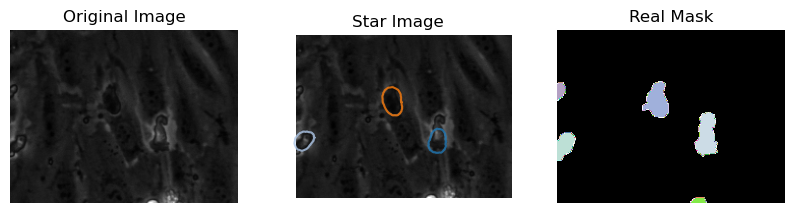

  5%|██                                          | 1/21 [00:01<00:28,  1.45s/it]

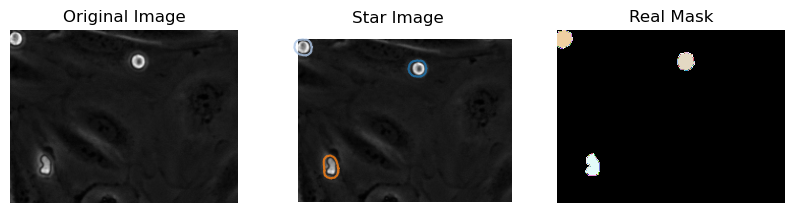

 10%|████▏                                       | 2/21 [00:01<00:14,  1.30it/s]

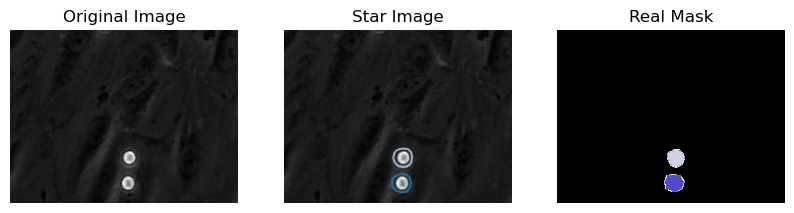

 14%|██████▎                                     | 3/21 [00:01<00:09,  1.90it/s]

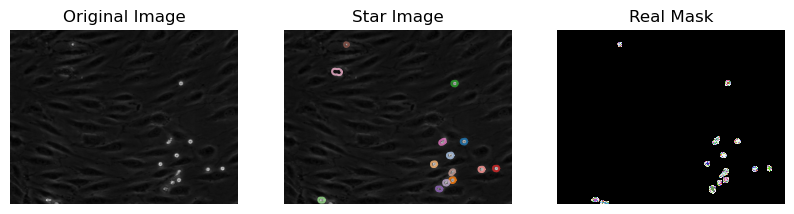

 19%|████████▍                                   | 4/21 [00:04<00:22,  1.35s/it]

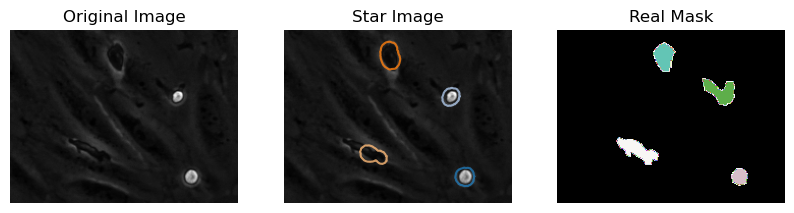

 24%|██████████▍                                 | 5/21 [00:04<00:15,  1.04it/s]

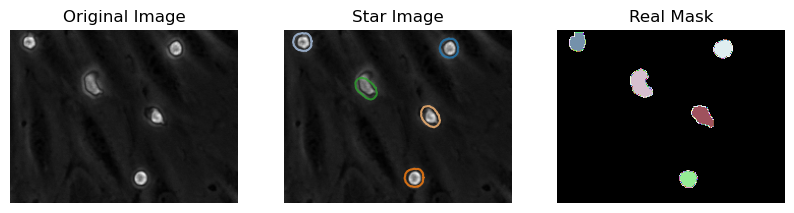

 29%|████████████▌                               | 6/21 [00:05<00:10,  1.40it/s]

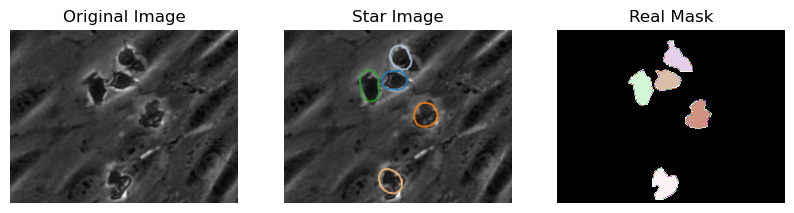

 33%|██████████████▋                             | 7/21 [00:05<00:07,  1.79it/s]

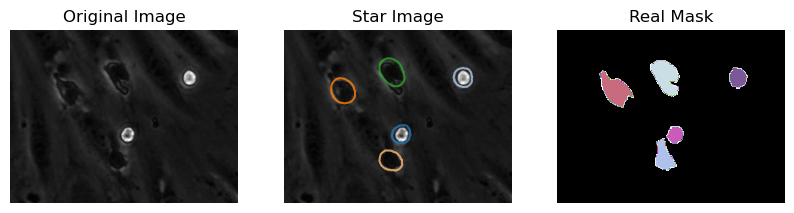

 38%|████████████████▊                           | 8/21 [00:05<00:05,  2.20it/s]

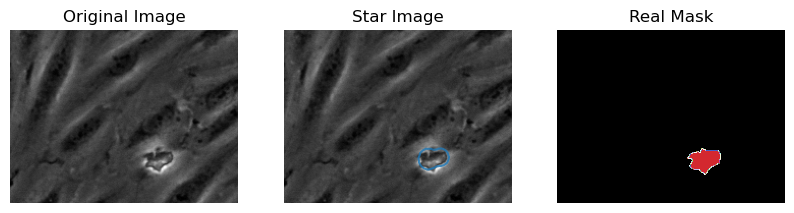

 48%|████████████████████▍                      | 10/21 [00:05<00:03,  3.45it/s]

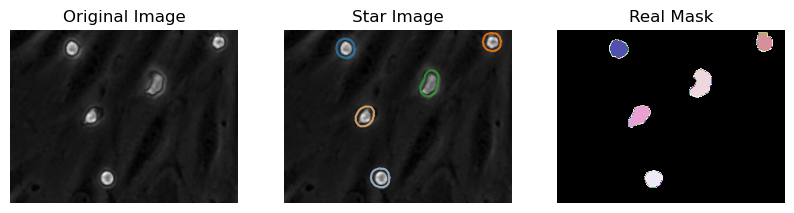

 52%|██████████████████████▌                    | 11/21 [00:06<00:02,  3.66it/s]

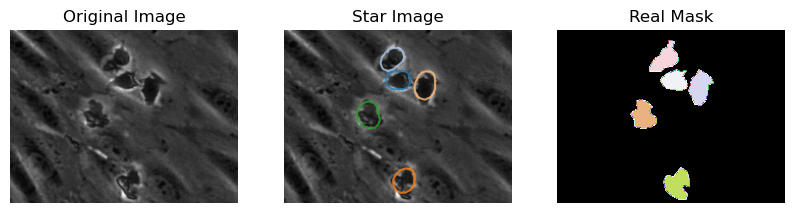

 57%|████████████████████████▌                  | 12/21 [00:06<00:02,  3.86it/s]

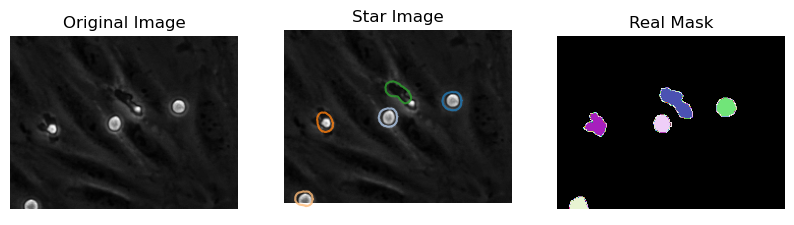

 62%|██████████████████████████▌                | 13/21 [00:06<00:01,  4.03it/s]

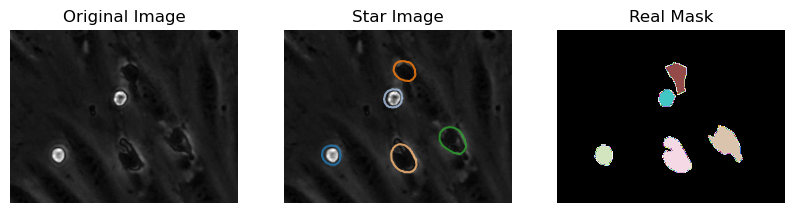

 67%|████████████████████████████▋              | 14/21 [00:06<00:01,  4.19it/s]

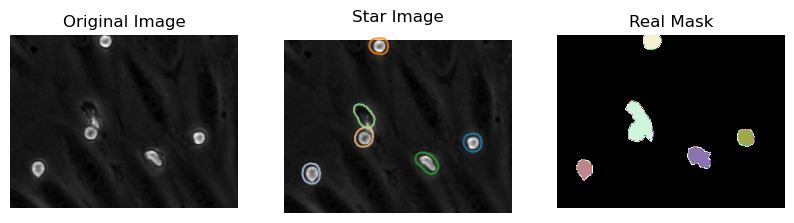

 71%|██████████████████████████████▋            | 15/21 [00:06<00:01,  4.31it/s]

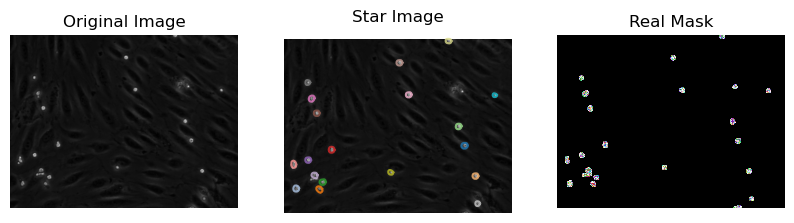

 76%|████████████████████████████████▊          | 16/21 [00:07<00:02,  2.29it/s]

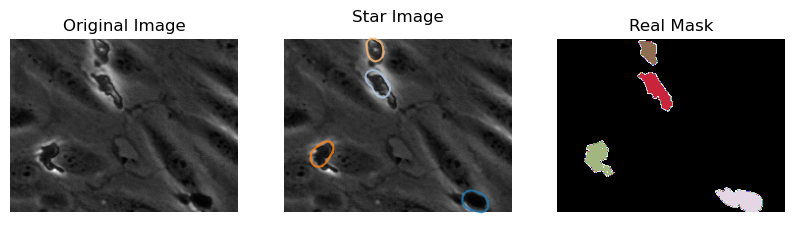

 81%|██████████████████████████████████▊        | 17/21 [00:08<00:01,  2.54it/s]

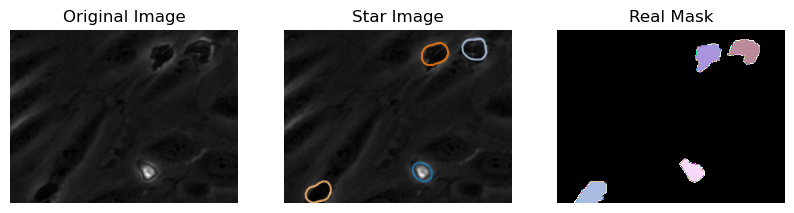

 86%|████████████████████████████████████▊      | 18/21 [00:08<00:01,  2.93it/s]

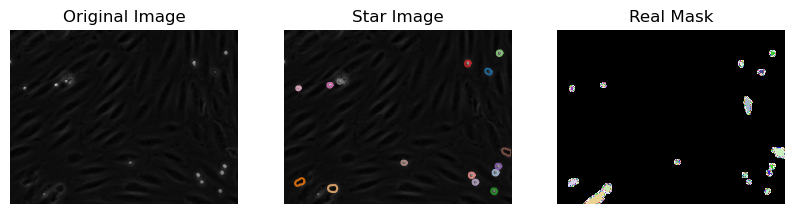

 90%|██████████████████████████████████████▉    | 19/21 [00:08<00:00,  2.63it/s]

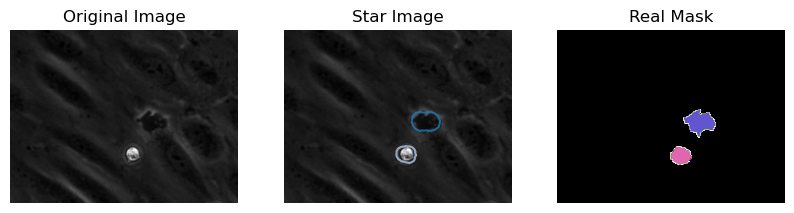

 95%|████████████████████████████████████████▉  | 20/21 [00:09<00:00,  2.94it/s]

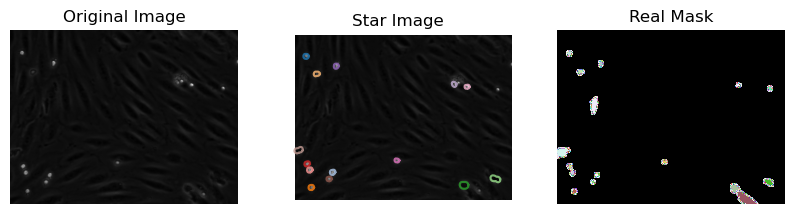

100%|███████████████████████████████████████████| 21/21 [00:09<00:00,  2.21it/s]

final ap score: 0.878497899159664


In [ ]:
#@markdown ### Prediction
from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap,ray_angles,draw_polygons
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label

model = 'starunet.pth' # @param ['starunet.pth', 'best_starunet.pth']

bestmodel = Star_unet.load_model(model, n_channels=1, n_classes=4)
bestmodel = bestmodel.to(device)


def calculate_miou(predicted, target):

    predicted_label = label(predicted, connectivity=1)
    target_label = label(target, connectivity=1)

    unique_predicted_labels = np.unique(predicted_label)
    unique_target_labels = np.unique(target_label)

    iou_scores = []
    for p_label in unique_predicted_labels:
        if p_label == 0:
            continue
        p_mask = predicted_label == p_label
        for t_label in unique_target_labels:
            if t_label == 0:
                continue
            t_mask = target_label == t_label
            intersection = np.logical_and(p_mask, t_mask).sum()
            union = np.logical_or(p_mask, t_mask).sum()
            if union == 0:
                continue
            iou_score = intersection / union
            iou_scores.append(iou_score)

    miou = np.mean(iou_scores) if iou_scores else 0
    return miou


predict_image_dir = './content/test/starimgs' #@param{type:"string"}
target_path = './content/test/starmasks' #@param{type:"string"}
iouThre = 0.5 #@param{type:"number"}
probthre = 0.7 #@param{type:"number"}

def calculate_isa(predicted, target):
    correct_pixels = (predicted == target).sum()
    total_pixels = target.size
    isa = correct_pixels / total_pixels
    return isa


show_images = True  #@param{type:"boolean"}
doclahe = False #param{type:"boolean"}@
dgeCanny = False #param{type:"boolean"}@
lbp = False #param{type:"boolean"} @
def visualize_predictions(image_dir, model):
    iou_scores = []
    isa_scores = []
    apscore_nms = []
    all_confusion_matrices = []

    transform = transforms.Compose([
        transforms.ToTensor(),
    ]) #        transforms.Resize((256, 256)),

    apscore_nms = []
    prob_thresh = 0.6

    for filename in tqdm(os.listdir(image_dir)):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            star_path = os.path.join(target_path, filename)

            target = io.imread(star_path)
            distances = star_dist(target,64)
            distances = np.transpose(distances,(2,0,1))
            obj_probabilities = edt_prob(target)
            obj_probabilities = np.expand_dims(obj_probabilities,0)

            distances = torch.from_numpy(np.array(distances))

            image = Image.open(image_path).convert('L')
            image_np = np.array(image)

            image_transform = transform(image_np)
            channels = [image_transform]
            channels[0] = channels[0].squeeze(0).numpy()

            if doclahe:
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                image_clahe = clahe.apply(image_np)
                channels.append(image_clahe)

            if edgeCanny:
                edges = cv2.Canny(image_np, 100, 200)
                channels.append(edges)

            if lbp:
                lbp_image = local_binary_pattern(image_np, P=8, R=1, method="uniform")
                lbp_image_normalized = cv2.normalize(lbp_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                channels.append(lbp_image_normalized)

            if len(channels) > 1:
                # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
                image_combined = np.stack(channels, axis=-1)
            else:
                image_combined = channels[0]

            image_combined = torch.from_numpy(image_combined).float()
            if len(image_combined.size())==3:
                image_combined = image_combined.permute(2, 0, 1)
            else:
                image_combined = image_combined.unsqueeze(0)
            image_combined = image_combined.unsqueeze(0).to(device)

            # input_image = transform(image).unsqueeze(0).to(device)

            bestmodel.eval()
            with torch.no_grad():
                starlist = bestmodel(image_combined)
                dist,prob = starlist
                dist_numpy= dist.detach().cpu().numpy().squeeze()
                prob_numpy= prob.detach().cpu().numpy().squeeze()

            dists = np.transpose(dist_numpy,(1,2,0))
            points, prob, dist = non_maximum_suppression(dists,
                                                         prob_numpy,nms_thresh=0.01, prob_thresh=probthre)
            coord = dist_to_coord(dist, points) #dist
            #points = non_maximum_suppression(coord,prob_numpy,prob_thresh=prob_thres)
            star_label = polygons_to_label(dist,points, shape = np.array(image).shape)
            # apscore_nms.append(metric.calculateAPScore(star_label,target,IOU_tau=0.5))
            #plot(target,star_label)
            target_binary = (target > 0).astype(np.uint8)
            prediction_binary = (prob_numpy > prob_thresh).astype(np.uint8)

            cmap = plt.get_cmap('tab20')

            fig, axes = plt.subplots(1, 3, figsize=(10, 5))
            scores = np.ones(np.array(image).shape)
            # print(scores)

            axes[0].imshow(np.array(image), cmap='gray')
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(np.array(image), cmap='gray')
            #axes[1].imshow(star_label, cmap=random_label_cmap())
            for i, poly in enumerate(coord):
                color = cmap(i % cmap.N)
                axes[1].plot(poly[1], poly[0], color=color, lw=1.5, alpha=0.8)
            axes[1].set_title('Star Image')
            axes[1].axis('off')

            axes[2].imshow(np.array(target), cmap=random_label_cmap())
            axes[2].set_title('Real Mask')
            axes[2].axis('off')

            # iou_score = calculate_miou(prediction_binary, target_binary)
            # isa_score = calculate_isa(prediction_binary, target_binary)
            ap_score = calculateAPScore(star_label,target,IOU_tau=iouThre)
            # confusion_matrix = generate_confusion_matrix(target_binary.flatten(), prediction_binary.flatten())

            # iou_scores.append(iou_score)
            # isa_scores.append(isa_score)
            # all_confusion_matrices.append(confusion_matrix)
            apscore_nms.append(ap_score)

            # print(f"Image: {filename}")
            # print(f"IOU Score: {iou_score}")
            # print(f"ISA Score: {isa_score}")
            # print(f"AP Score: {ap_score}")
            # print(f"Confusion Matrix:\n{confusion_matrix}\n")

            if show_images:
                plt.show()
            else:
                plt.close()
    ap_nms = sum(apscore_nms)/(len(apscore_nms))
    print(f'final ap score: {ap_nms}')

visualize_predictions(predict_image_dir, model)

In [ ]:
%%capture
#@markdown ### Out of memory Kill and reset
import shutil
import torch
try:
    shutil.rmtree('/content/test/')
    shutil.rmtree('/content/data_stardist/')
except:
    pass

! unzip -o -q data_stardist.zip
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Device Index:", current_device)
    print("Device Name:", torch.cuda.get_device_name(current_device))
    print("Device Memory Allocated:", torch.cuda.memory_allocated(current_device))
    print("Device Memory Cached:", torch.cuda.memory_reserved(current_device))
    torch.cuda.empty_cache()
    print("Device Memory Cached after empty:", torch.cuda.memory_reserved(current_device))

Device Index: 0
Device Name: Tesla T4
Device Memory Allocated: 35627008
Device Memory Cached: 2449473536
Device Memory Cached after empty: 48234496
